# Simulated live in-situ melting

This notebook simulates a live experiment where a diffraction pattern of a specimen is recorded while the temperature is cycled. A simple measure of the crystallinity of the specimen is recorded with the CrystallinityUDF in LiberTEM. DENS ImpulsePy is used to control and measure the heating.

For simplicity a `MemoryAcquisition`is used instead of the Merlin simulator. See the other examples on how to set up and connect to a Quantum Detectors Merlin camera!

In [1]:
%matplotlib nbagg

In [2]:
import os
import logging
import time
import datetime
import concurrent.futures


import numpy as np
import ipywidgets
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
from libertem.udf.crystallinity import CrystallinityUDF
from libertem.udf.base import UDF


# ImageGL-accelerated plot for fast live display
from libertem.viz.bqp import BQLive2DPlot
# Alternatively a version that uses the slower, but more mature Matplotlib
from libertem.viz.mpl import MPLLive2DPlot

# A function that can cenerate very basic CBED frames
from libertem.utils.generate import cbed_frame

INFO:empyre:Imported EMPyRe V-0.3.0 GIT-7531a074e8e81c3e02d65fad075edcd2c5408ad7


In [5]:
from libertem_live.api import LiveContext
from libertem_live.udf.monitor import SignalMonitorUDF

In [6]:
import impulsePy as impulse

INFO:root:
 Subscribed to impulse events. 


## Start a live context

Currently, this uses the InlineJobExecutor, meaning everything happens in the same process. This notebook is not tested with a distributed executor.

In [7]:
ctx = LiveContext()

## Generate very basic diffraction data

Just regular peaks for starting condition and recrystallized state, and a zero order disk and diffuse ring for the melt.

In [8]:
a_1 = (11, 2)
b_1 = (-3, 13)
indices_1 = np.mgrid[-2:3, -2:3]
diffracted_1, _, _ = cbed_frame(
    fy=128, fx=128,
    a=a_1,
    b=b_1,
    indices=indices_1
)
melted, _, _ = cbed_frame(
    fy=128, fx=128,
    indices=np.array([(0, 0)])
)
a_2 = (9, 9)
b_2 = (-9, 7)
indices_2 = np.mgrid[-2:4, -1:4]
diffracted_2, _, _ = cbed_frame(
    fy=128, fx=128,
    a=a_2,
    b=b_2,
    indices=indices_2
)
y, x = np.ogrid[-64:64, -64:64]
distance = np.sqrt(y**2 + x**2)
ring = (distance > 12) * (distance <= 15)
melted[:, ring] = 1

<IPython.core.display.Javascript object>


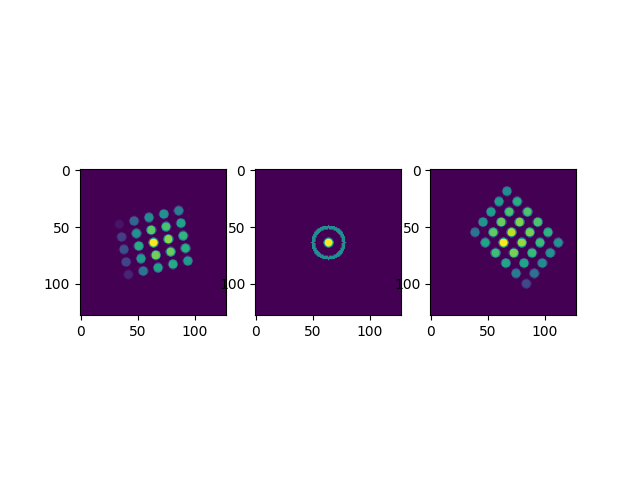

In [9]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(diffracted_1[0])
axes[1].imshow(melted[0])
axes[2].imshow(diffracted_2[0])

## Stack the data

This can then be used to create a `MemoryAcquisition`.

In [10]:
# Prepare data for a mock temperature sweep
data = np.zeros((5000, 128, 128), dtype=np.float32)
data[:2000] = diffracted_1[0]
data[2000:3000] = melted[0]
data[3000:] = diffracted_2[0]

## Initialize ImpulsePy

In [11]:
impulse.heat.data.subscribe()

INFO:root:
 Subscribed to heat data. 


In [12]:
impulse.waitForControl()

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\users\dwebe\.conda\envs\libertem\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\dwebe\.conda\envs\libertem\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\users\dwebe\.conda\envs\libertem\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_ins

## Load a sweep

Ramp to 500 °C in 13 s, hold for 1 s, ramp to 21 °C in 13 s worked timing-wise on my machine

In [13]:
sweep_file = os.path.abspath('sweep.temp.prf')

In [14]:
impulse.profile.load(sweep_file)

'ok'

## Trigger function

This callback function is called by LiberTEM as soon as everything is set up to receive data. Here it just starts the temperature profile. In a real experiment it would also trigger the camera or other hardware.

In [15]:
def trigger(aq):
    impulse.profile.control('play')

## Declare the acquisition

Here we have a single nav dimension (time series). See the other examples on how this is done with a real camera.

In [16]:
aq = ctx.prepare_acquisition(
    'memory',
    data=data,
    # Throttle the speed to simulate a real detector
    # and make the timing less dependent on processing speed
    tiledelay=0.02,
    trigger=trigger,
    nav_shape=(5000, ),
    sig_shape=(128, 128),
    # Many partitions to get finer temporal resolution
    # and allow quick updates of the live plots
    num_partitions=500,
)

In [17]:
def get_time(stamp):
    '''
    Helper function to convert Impulse time stamps to Unix time
    '''
    stamp, decimals = stamp.split('.')
    decimals = decimals[:-1]
    form = '%Y-%m-%dT%H:%M:%S'
    res = time.mktime(time.strptime(stamp, form))
    return res + int(decimals)/10**len(decimals)

In [18]:
cryst = CrystallinityUDF(
    rad_in=3,
    rad_out=40,
    real_center=(64, 64),
    real_rad=5
)

## UDF to record in-situ data

Here the data is just recorded and the detector data is ignored. In a more involved example, one could use the in-situ data as input for data processing or even control an experiment based on the processing result.

In the future, data streams from in-situ experiments or other sources might be available as AUX data since this example here will likely only work well with the `InlineJobExecutor` and not with a distributed executor.

In [19]:
class TemperatureRecorderUDF(UDF):
    def get_result_buffers(self):
        return {
            'temperature': self.buffer(kind='nav', dtype=np.float32),
            'time': self.buffer(kind='nav', dtype=np.float64),
        }
    
    # Somewhat coarser sampling (partition instead of frame) since we only get one update per second
    def process_partition(self, partition):
        last_data = impulse.heat.data.getLastData()
        self.results.temperature[:] = last_data['temperatureMeasured']
        #print(last_data['timeStamp'], get_time(last_data['timeStamp']))
        self.results.time[:] = get_time(last_data['timeStamp'])

## Set up UDFs and plots

We instantiate the UDFs and create plots that will be updated live.

The first two UDFs record data, the last monitors the experiment by showing the most recent detector frame.

In [20]:
udfs = [cryst, TemperatureRecorderUDF(), SignalMonitorUDF()]

In [21]:
# This is a fast LiberTEM live plot for the monitor.
# The other plots are custom
p0 = BQLive2DPlot(aq, udfs[2])

Figure(axes=[Axis(label='x', scale=LinearScale(max=1.0, min=0.0)), Axis(label='y', orientation='vertical', sca…

<IPython.core.display.Javascript object>


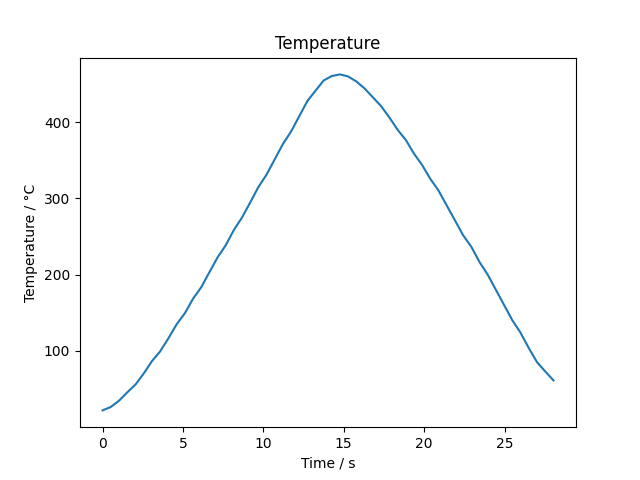

<IPython.core.display.Javascript object>


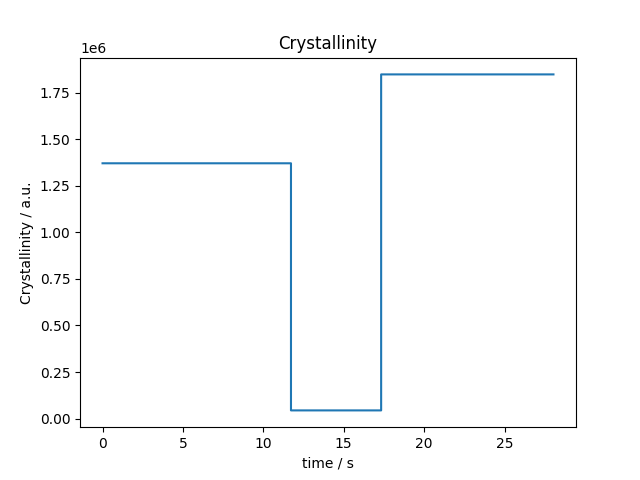

<IPython.core.display.Javascript object>


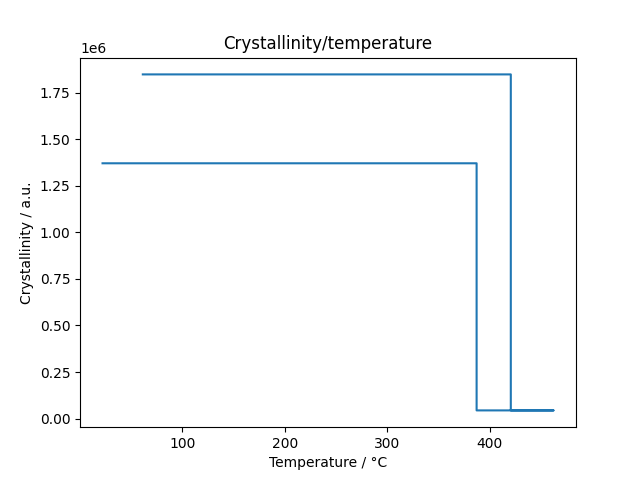

Text(0, 0.5, 'Crystallinity / a.u.')

In [22]:
p0.display()
axes = []
fig, a = plt.subplots()
axes.append(a)
fig, a = plt.subplots()
axes.append(a)
fig, a = plt.subplots()
axes.append(a)

# Temperature over time
temperature_plot, = axes[0].plot((), ())
axes[0].set_title("Temperature")
axes[0].set_xlabel('Time / s')
axes[0].set_ylabel('Temperature / °C')

# Crystallinity over time
crystallinity_plot, = axes[1].plot((), ())
axes[1].set_title("Crystallinity")
axes[1].set_xlabel('time / s')
axes[1].set_ylabel('Crystallinity / a.u.')

# Crystallinity as a function of temperature
relative_plot, = axes[2].plot((), ())
axes[2].set_title("Crystallinity/temperature")
axes[2].set_xlabel('Temperature / °C')
axes[2].set_ylabel('Crystallinity / a.u.')

### Run one scan

The live plots above are updated with the results

In [23]:
%%time
last_update = -np.inf

# With run_udf_iter() we get access to the intermediate results
# after merging each partition result. That allows us to update our
# custom plots live. This is also a good place to implement
# control loops for the experiment in most cases.

for res in ctx.run_udf_iter(dataset=aq, udf=udfs, plots=[p0, ]):
    timestamp = time.time()
    # Throttle update rate since matplotlib can't keep up with fast updates
    if timestamp - last_update > 0.5:
        # res.damage is a boolean array that is true for all points of the acquisition
        # that have been processed already. That way we can limit the plotting
        # to valid data
        
        temperatures = res.buffers[1]['temperature'].data[res.damage]
        times = res.buffers[1]['time'].data[res.damage]
        times -= times[0]
        crystallinity = res.buffers[0]['intensity'].data[res.damage]
        # print(times[-1], temperatures[-1], crystallinity[-1])

        relative_plot.set_xdata(temperatures)
        relative_plot.set_ydata(crystallinity)

        temperature_plot.set_ydata(temperatures)
        temperature_plot.set_xdata(times)

        crystallinity_plot.set_ydata(crystallinity)
        crystallinity_plot.set_xdata(times)

        for a in axes:
            a.relim()
            a.autoscale()
            a.figure.canvas.draw()
        last_update = timestamp
print("Finished.")

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\users\dwebe\.conda\envs\libertem\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\users\dwebe\.conda\envs\libertem\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "c:\users\dwebe\.conda\envs\libertem\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\users\dwebe\.conda\envs\libertem\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\dwebe\.cond

Finished.
Wall time: 29.2 s
